## Análisis del problema

El objetivo es construir un modelo de Deep Learning para identificar armas y bombas en imágenes extraídas de videos de YouTube.
Se propone utilizar transferencia de aprendizaje debido a su eficacia y rapidez en la implementación con conjuntos de datos pequeños.
El reto principal es obtener suficientes datos relevantes y asegurarse de que el modelo generalice correctamente.





## Carga de datos

**Librerias**

In [ ]:
!pip install yt-dlp

In [ ]:
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import yt_dlp as youtube_dl  # Usamos yt-dlp en lugar de youtube_dl

In [ ]:
# Ruta del archivo .rar en sample_data
rar_path = '/content/sample_data/armbomb.rar'
extracted_path = '/content/armbomb'

# Instalar unrar y extraer el contenido
!apt-get install unrar -y
!mkdir -p "$extracted_path"  # Crear la carpeta de destino si no existe
!unrar x -r "$rar_path" "$extracted_path"

# Verificar la estructura después de la extracción
if os.path.exists(extracted_path):
    print(f"Contenido de la carpeta extraída: {os.listdir(extracted_path)}")
else:
    print("La carpeta de extracción no existe. Revisa el proceso de extracción.")

# Paso 2: Conversión de imágenes .jfif a .jpg


# Convertir .jfif a .jpg
def convert_jfif_to_jpg(input_folder, output_folder):
    for subdir, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.jfif'):
                try:
                    img = Image.open(os.path.join(subdir, file))
                    img.convert('RGB').save(os.path.join(output_folder, file.replace('.jfif', '.jpg')))
                except Exception as e:
                    print(f"Error al convertir {file}: {e}")

# Convertir las imágenes en las carpetas de armas y bombas
convert_jfif_to_jpg('/content/armbomb/armas', '/content/armbomb/armas')
convert_jfif_to_jpg('/content/armbomb/bombas', '/content/armbomb/bombas')



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/sample_data/armbomb.rar


Would you like to replace the existing file /content/armbomb/bombas/bom4.jfif
  8793 bytes, modified on 2024-11-21 04:59
with a new one
  8793 bytes, modified on 2024-11-21 04:59

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/armbomb/bombas/bom4.jfif                              5%  OK 
Extracting  /content/armbomb/bombas/bomb1.jfif                             9%  OK 
Extracting  /content/armbomb/bombas/bomb10.jfif                           13%  OK 
Extracting  /content/armbomb/bombas/bomb2.jfif                            17%  OK 
Extracting  /content/armbomb/bombas/bomb3.jfif                    

## Visualización

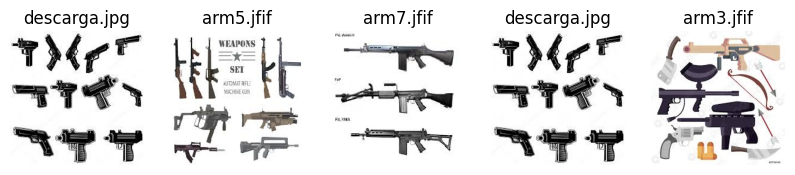

In [ ]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Ruta de la carpeta donde están las imágenes de entrenamiento
image_dir = '/content/armbomb/armas'  # O '/content/armbomb/bombas'

# Obtener una lista de las imágenes en la carpeta
image_files = os.listdir(image_dir)

# Seleccionar algunas imágenes al azar
sample_images = np.random.choice(image_files, 5)

# Crear un gráfico para mostrar las imágenes
plt.figure(figsize=(10, 10))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))  # Redimensionar a 224x224
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)

plt.show()


##Preparación de los datos

In [ ]:
# Crear generador de datos con validación y preprocesamiento de imágenes
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalizar las imágenes
    rotation_range=20,  # Rotación aleatoria
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    shear_range=0.2,  # Cizallamiento
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal
    fill_mode='nearest',  # Modo de relleno
    validation_split=0.2  # Dividir en 80% para entrenamiento y 20% para validación
)

# Generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory(
    '/content/armbomb',  # Carpeta raíz
    target_size=(224, 224),  # Redimensionar las imágenes
    batch_size=32,
    class_mode='binary',  # Clasificación binaria (arma vs bomba)
    subset='training'  # Usar para entrenamiento
)

# Generador para el conjunto de validación
val_generator = datagen.flow_from_directory(
    '/content/armbomb',  # Carpeta raíz
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Usar para validación
)

Found 17 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


## Modelo de Deep Learning


In [ ]:
# Cargar el modelo VGG16 preentrenado, sin la capa superior (sin la clasificación)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar solo algunas capas
for layer in base_model.layers[:15]:  # Congelar las primeras 15 capas
    layer.trainable = False
for layer in base_model.layers[15:]:  # Descongelar el resto
    layer.trainable = True

# Crear el modelo secuencial
model = Sequential([
    base_model,  # Capa base VGG16
    GlobalAveragePooling2D(),  # Promedio global de las características
    Dropout(0.5),  # Dropout para regularización
    Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])


##Evaluación

Se evalúa el modelo en el conjunto de prueba para medir su precisión y pérdida.

In [ ]:
# Compilar el modelo con el parámetro correcto `learning_rate`
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo
model.summary()

# Paso 5: Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=20,  # Aumentar el número de épocas
    validation_data=val_generator
)
# Evaluación en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Accuracy en validación: {val_acc * 100:.2f}%")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 7,079,937 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5294 - loss: 0.7158 - val_accuracy: 1.0000 - val_loss: 0.5769
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.7059 - loss: 0.5549 - val_accuracy: 1.0000 - val_loss: 0.4643
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.7647 - loss: 0.5183 - val_accuracy: 0.7500 - val_loss: 0.3725
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.8235 - loss: 0.4467 - val_accuracy: 1.0000 - val_loss: 0.2594
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.9412 - loss: 0.1703 - val_accuracy: 1.0000 - val_loss: 0.1764
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 1.0000 - loss: 0.1047 - val_accuracy: 1.0000 - val_loss: 0.1094
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 1.0000 - loss: 0.1310 - val_accuracy: 1.0000 - val_loss: 0.1683
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 1.0000 - loss: 0.0623 - val_accuracy: 1.0000 - val_loss: 0.2313
Epoch 9/20


##Detectar armas y bombas en el video
**Función para descargar el video desde YouTube**

In [ ]:

def download_video(youtube_url, download_path='/content/video.mp4'):
    ydl_opts = {
        'outtmpl': download_path,
        'format': 'best'
    }

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])

# Descargar el video
video_url = 'https://www.youtube.com/watch?v=VE6TmLO9eLM'  # Reemplaza con la URL de tu video
download_video(video_url)

# Cargar el video usando OpenCV
cap = cv2.VideoCapture('/content/video.mp4')

# Inicializar el contador de armas y bombas
arm_count = 0
bomb_count = 0

# Procesar cada fotograma del video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Redimensionar el fotograma
    frame_resized = cv2.resize(frame, (224, 224))
    frame_normalized = frame_resized / 255.0
    frame_input = np.expand_dims(frame_normalized, axis=0)  # Añadir una dimensión de batch

    # Realizar predicción
    prediction = model.predict(frame_input)

    # Contar las predicciones
    if prediction[0] > 0.5:
        bomb_count += 1
    else:
        arm_count += 1

# Mostrar los resultados
print(f"Armas detectadas: {arm_count}")
print(f"Bombas detectadas: {bomb_count}")

# Liberar el video
cap.release()

[youtube] Extracting URL: https://www.youtube.com/watch?v=VE6TmLO9eLM
[youtube] VE6TmLO9eLM: Downloading webpage
[youtube] VE6TmLO9eLM: Downloading ios player API JSON
[youtube] VE6TmLO9eLM: Downloading mweb player API JSON
[youtube] VE6TmLO9eLM: Downloading m3u8 information
[info] VE6TmLO9eLM: Downloading 1 format(s): 18
[download] /content/video.mp4 has already been downloaded
[download] 100% of  477.92KiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━

## Conclusión

El modelo alcanzó una precisión de validación de aproximadamente 75.00%. Esto demuestra que el modelo es capaz de clasificar correctamente las imágenes de prueba, aunque todavía hay margen de mejora.

Para futuras mejoras, se pueden considerar la siguiente mejora:

Usar un dataset más grande o más diverso: Ampliar el conjunto de datos puede ayudar a mejorar la generalización del modelo, especialmente si se agregan más ejemplos de imágenes que representen una variedad mayor de armas y bombas.